# Salary Predictions Based on Job Descriptions

## DEFINE

This is a project aimed for predicting future salaries of job postings based on salaries of current job postings. The language of choice to tackle this problem is Python.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
__author__ = "Lukas Barbuscak"
__email__ = "lukas.barbuscak@gmail.com"

## DISCOVER

In [2]:
#loading the data
df_features = pd.read_csv("data\\train_features.csv")
df_salaries = pd.read_csv("data\\train_salaries.csv")
df_test = pd.read_csv("data\\test_features.csv")

#merging the features and salaries datasets based on JobId
df = pd.merge(df_features, df_salaries, on="jobId")

#deleting unnecessary dataframes
del df_features, df_salaries

#examining the dataset
df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


### Cleaning the dataset

In [3]:
#checking the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


Overall, the dataset looks very clean. Numeric values are stored as floats and string values are stored as objects. Let's check for any possible irregularities in the data.

In [4]:
#checking for the total number of missing values
df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [5]:
#checking if missing values are encoded as "0"
df.eq(0).sum()

jobId                      0
companyId                  0
jobType                    0
degree                     0
major                      0
industry                   0
yearsExperience        39839
milesFromMetropolis    10123
salary                     5
dtype: int64

I assume that 0 in years of experience is not a sign of missing values, since someone can have experience less than 1 year. I also assume that miles from Metropolis being 0 is not an issue, since being from Metropolis means distance to Metropolis would indeed be 0. However, salary being 0 either indicates a missing value, or volunteering, and that is not relevant for the model. I will drop the observations.

In [6]:
#dropping observations which have salary as 0
df.drop(df[df.salary == 0].index, inplace=True)

In [7]:
#checking for possible irregularities for object dtypes
print("Job type values:", df.jobType.unique())
print("Degree values:", df.degree.unique())
print("Major values:", df.major.unique())
print("Industry values:", df.industry.unique())

Job type values: ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR']
Degree values: ['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE']
Major values: ['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING']
Industry values: ['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE']


In [8]:
#checking for possible irregularities for numeric dtypes
df.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


There seem to be no issues with the first two columns, but salary might have possible outliers. Let's check this using a box plot.

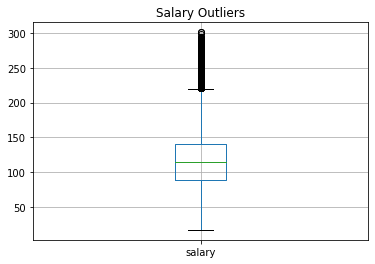

In [9]:
#creating a box plot
df.boxplot(column=["salary"])
plt.title("Salary Outliers")
plt.show()

In [10]:
#checking the percentage of outliers
salary_outliers = np.sum(df["salary"]>=210)
print("The percentage of outliers is:", salary_outliers/df["salary"].count()*100)

The percentage of outliers is: 1.3569067845339227


Because the percentage is relatively large and they do not appear to be errors, I will keep the outliers in the dataset.

In [11]:
#checking for duplicate Job ID values
df_no_duplicates = df.drop('jobId', axis=1).drop_duplicates()
print(df.shape)
print(df_no_duplicates.shape)

(999995, 9)
(999809, 8)


In [12]:
#applying the changes to the original dataset
df = df_no_duplicates
print(df.shape)

del df_no_duplicates

(999809, 8)


### Exploratory Data Analysis

In [13]:
#checking the differences between groups, and plotting them if necessary
companyId_summary=df.groupby("companyId")
companyId_summary.mean().head(10)

,yearsExperience,milesFromMetropolis,salary
companyId,,,
COMP0,12.075401,49.843772,115.970057
COMP1,11.902687,49.386469,116.056655
COMP10,11.877397,49.458095,116.028544
COMP11,12.021550,49.687272,116.116005
COMP12,12.041830,49.786792,116.099886
COMP13,12.101874,49.671243,116.567613
COMP14,12.054134,49.331279,116.315561
COMP15,11.923198,49.786829,115.853944
COMP16,11.981686,49.266223,116.370342


In [14]:
degree_summary = df.groupby("degree")
degree_summary.mean()

,yearsExperience,milesFromMetropolis,salary
degree,,,
BACHELORS,11.985971,49.589377,125.454887
DOCTORAL,12.003330,49.608671,135.491660
HIGH_SCHOOL,11.996087,49.456664,101.930078
MASTERS,11.984964,49.553572,130.505844
NONE,11.991743,49.476235,98.184684


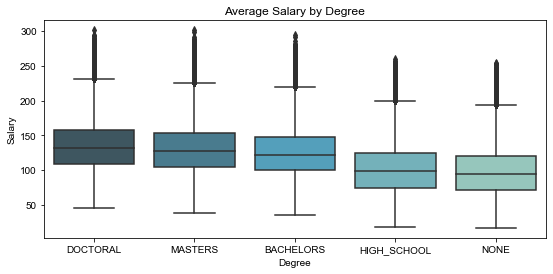

In [15]:
plt.figure(figsize=(9,4))
sns.boxplot(x=df["degree"],y=df["salary"], 
            palette=("GnBu_d"), order=["DOCTORAL","MASTERS","BACHELORS","HIGH_SCHOOL","NONE"])
sns.set(style="whitegrid")
plt.xlabel("Degree")
plt.ylabel("Salary")
plt.title("Average Salary by Degree")
plt.show()

In [16]:
jobType_summary = df.groupby("jobType")
jobType_summary.mean()

,yearsExperience,milesFromMetropolis,salary
jobType,,,
CEO,11.998149,49.477947,145.313280
CFO,11.990632,49.572544,135.459372
CTO,12.010421,49.579624,135.481310
JANITOR,11.971010,49.437723,70.821741
JUNIOR,11.992791,49.659437,95.335627
MANAGER,11.987123,49.498146,115.369547
SENIOR,11.996902,49.572885,105.489449
VICE_PRESIDENT,11.993739,49.428028,125.371106


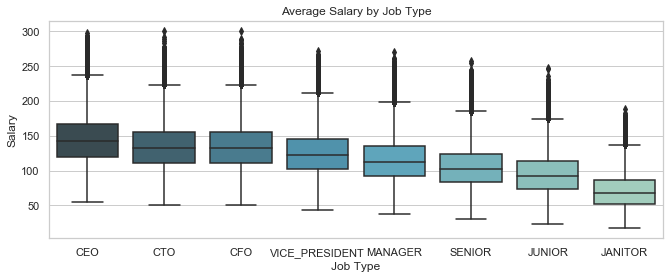

In [17]:
plt.figure(figsize=(11,4))
sns.boxplot(x=df["jobType"],y=df["salary"], 
            palette=("GnBu_d"), order=["CEO","CTO","CFO","VICE_PRESIDENT","MANAGER","SENIOR","JUNIOR","JANITOR"])
sns.set(style="whitegrid")
plt.xlabel("Job Type")
plt.ylabel("Salary")
plt.title("Average Salary by Job Type")
plt.show()

In [18]:
major_summary = df.groupby("major")
major_summary.mean()

,yearsExperience,milesFromMetropolis,salary
major,,,
BIOLOGY,11.991075,49.522322,127.934354
BUSINESS,12.011244,49.630251,135.648980
CHEMISTRY,11.975303,49.553589,129.072324
COMPSCI,11.978966,49.675374,132.075795
ENGINEERING,11.987883,49.577619,138.441342
LITERATURE,12.010991,49.694363,124.423097
MATH,11.992266,49.423045,133.322042
NONE,11.993534,49.483579,102.592129
PHYSICS,11.984625,49.554017,130.373408


In [19]:
industry_summary = df.groupby("industry")
industry_summary.mean()

,yearsExperience,milesFromMetropolis,salary
industry,,,
AUTO,11.974767,49.551268,109.443050
EDUCATION,12.000749,49.585029,99.456573
FINANCE,12.009780,49.531775,130.752100
HEALTH,11.973068,49.501443,115.742622
OIL,12.006494,49.488946,130.957452
SERVICE,11.994776,49.577169,104.452472
WEB,11.988602,49.462295,121.652428


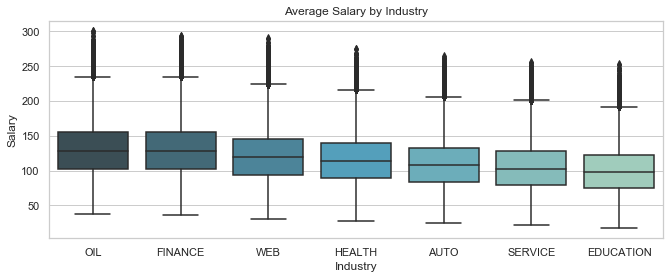

In [20]:
plt.figure(figsize=(11,4))
sns.boxplot(x=df["industry"],y=df["salary"], palette=("GnBu_d"),
           order=["OIL","FINANCE","WEB","HEALTH","AUTO","SERVICE","EDUCATION"])
sns.set(style="whitegrid")
plt.xlabel("Industry")
plt.ylabel("Salary")
plt.title("Average Salary by Industry")
plt.show()

Overall, all categorical variables show no mean differences between the categories and years of experience, or number of miles from Metropolis. The only differences in general seem to be in differences in salary.

We can see there is a difference between observations with high school/no education, and observations with master's/doctoral/bachelor's degrees, which have slight differences between each other as well. The job type bar graph does not say anything surprising about the data again, CEO observations have the highest salary, and janitor observations have the lowest. The mean differences between the majors are minimal, with the only significant visible difference is having a major or not having a major. There are differences between industries, with oil and finance being the with the highest mean, and service and education the lowest.

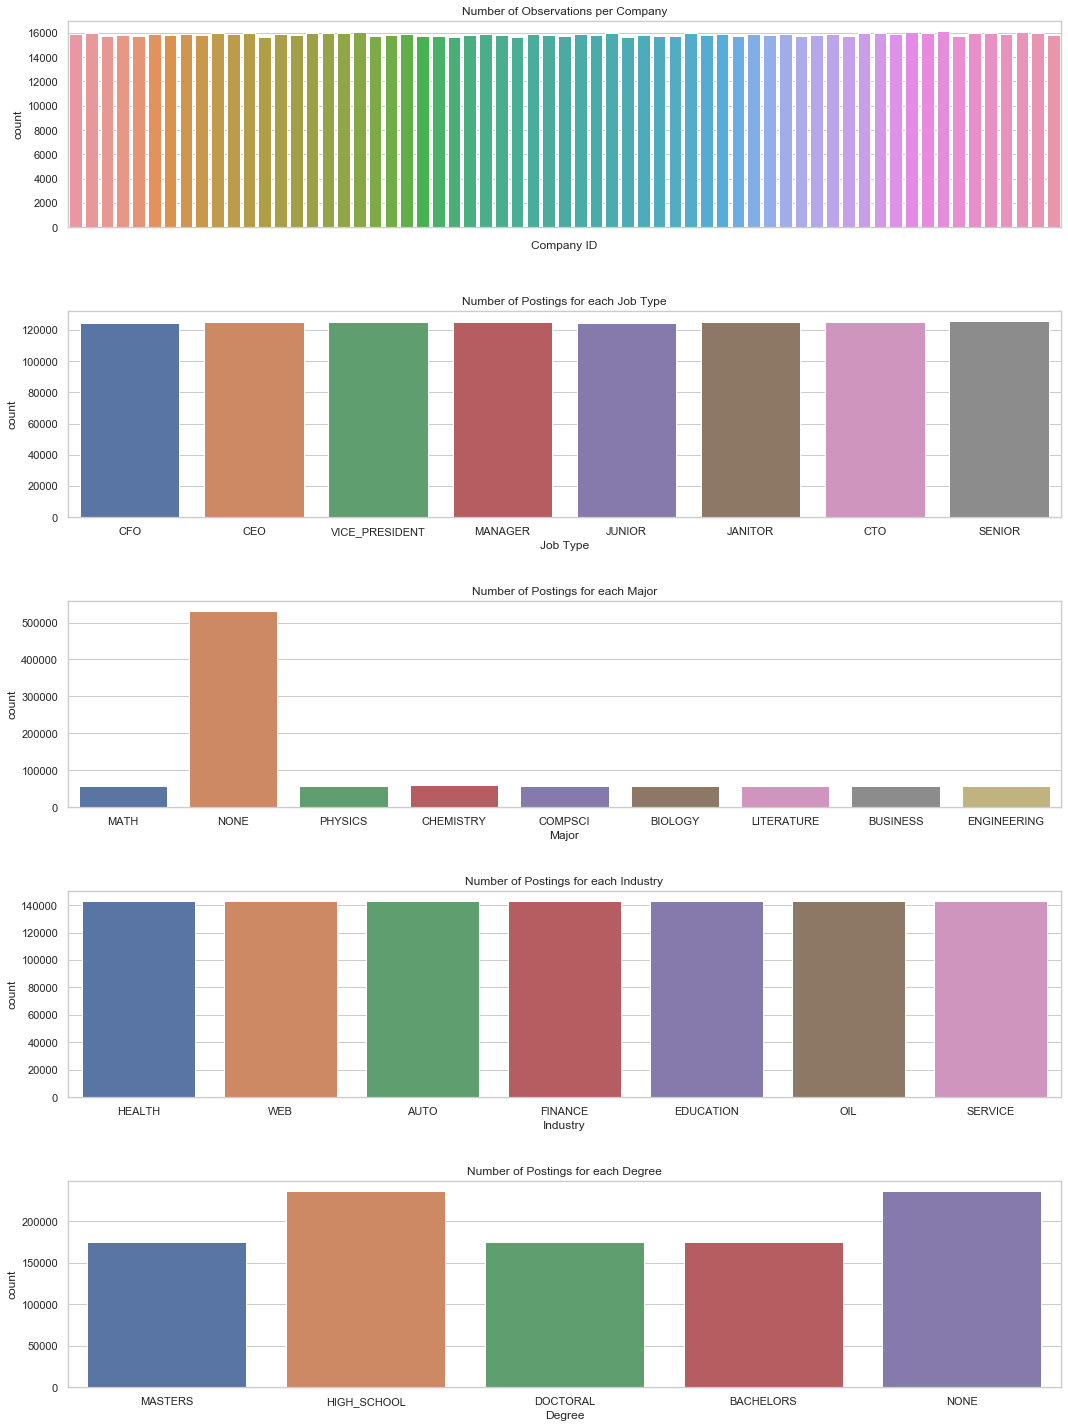

In [21]:
#creating a countplot for each categorical variable presented as a subplot
sns.set(style="whitegrid")
fig, ax = plt.subplots(5, 1, figsize=(15, 20))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
ax = fig.add_subplot(5, 1, 1)
sns.countplot(df['companyId'])
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.xlabel("Company ID")
plt.title("Number of Observations per Company")
ax = fig.add_subplot(5, 1, 2)
sns.countplot(df['jobType'])
plt.xlabel("Job Type")
plt.title("Number of Postings for each Job Type")
ax = fig.add_subplot(5, 1, 3)
sns.countplot(df['major'])
plt.xlabel("Major")
plt.title("Number of Postings for each Major")
ax = fig.add_subplot(5, 1, 4)
sns.countplot(df['industry'])
plt.xlabel("Industry")
plt.title("Number of Postings for each Industry")
ax = fig.add_subplot(5, 1, 5)
sns.countplot(df['degree'])
plt.xlabel("Degree")
plt.title("Number of Postings for each Degree")
plt.tight_layout(h_pad=3.0)
plt.show()

This dataset seems extremely balanced in terms of distribution of each categorical variable: the job type count is roughly the same for all job types, there is only slightly more people with no major/without post-secondary education in the dataset than their counterparts, and all industries and companies are represented roughly equally. This is a good sample in no need for applying any resampling methods.

Let's take a look at numerical variables.

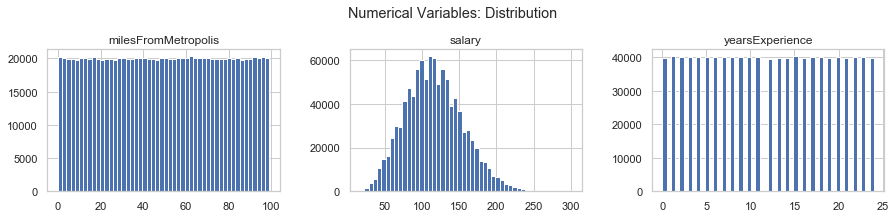

In [22]:
#defining a group of numerical variables
num = df.select_dtypes(include=[np.int64])

#distribution of numerical variables
num.hist(bins=50, figsize=(15, 6), layout=(2, 3))
plt.suptitle("Numerical Variables: Distribution")
plt.show()

This compact representation of distribution of the numerical variables shows some valuable information. The distance from Metropolis seems very similar for all the observations, and shows a uniform distribution. The salary graph shows slight skewness to the right, but the shape overall follows normal distribution. The years of experience variable shows again a uniform shape. This is explained by good sampling, and again, there is no need for any resampling methods.

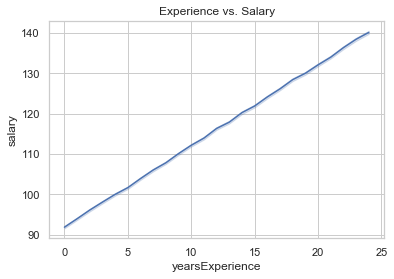

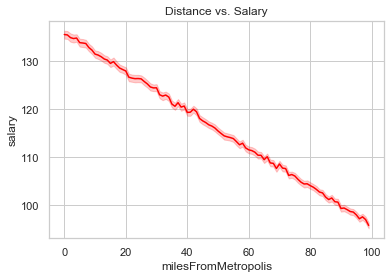

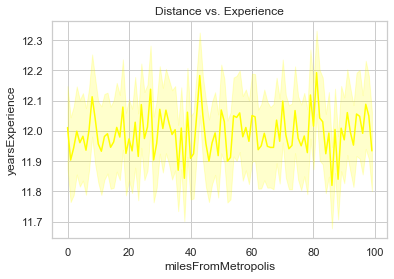

In [23]:
#drawing lineplots
sns.lineplot(x=df['yearsExperience'], y=df['salary'], data=df)
plt.title("Experience vs. Salary")
plt.show()

sns.lineplot(x=df['milesFromMetropolis'], y=df['salary'], data=df, color="red")
plt.title("Distance vs. Salary")
plt.show()

sns.lineplot(x=df['milesFromMetropolis'], y=df['yearsExperience'], data=df, color="yellow")
plt.title("Distance vs. Experience")
plt.show()

From the above graphs, we can see that salaries generally decrease with larger distance from Metropolis. Also, salaries tend to increase with years of experience in general. There does not seem to be a relationship between years of experience and miles from Metropolis. 

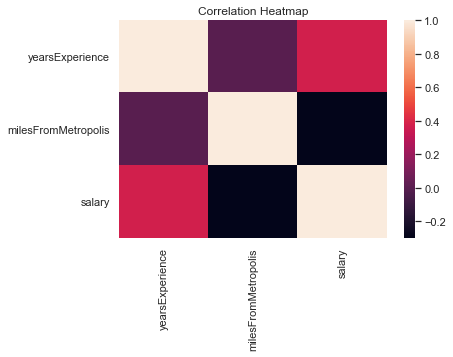

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000673,0.374991
milesFromMetropolis,0.000673,1.000000,-0.297679
salary,0.374991,-0.297679,1.000000


In [24]:
#creating a correlation heatmap and a correlation table
sns.heatmap(df.corr())
plt.title("Correlation Heatmap")
plt.show()
df.corr()

As expected, there is a positive correlation between years of experience and salary, and a slight negative correlation between miles from Metropolis and salary. There is no correlation between years of experience and miles from Metropolis.

The EDA has shown valuable information: I am dealing with a balanced dataset, and the relationship between the dependent variable and the predictors seems to be linear.

### Preprocessing

Because this is a regression problem with the dependent variable being a continuous one, MSE is a simple and fitting choice to use it as a metric for my model. As my baseline model, I will use difference from average salary, since every ML model should be able to outperform differences from the mean.

In [25]:
#creating dummies, appending them to the original dataset, and dropping the original columns
dummy_1 = pd.get_dummies(df["jobType"])
df = pd.concat([df, dummy_1], axis=1)
df.drop("jobType", axis = 1, inplace=True)

dummy_2 = pd.get_dummies(df["industry"])
df = pd.concat([df, dummy_2], axis=1)
df.drop("industry", axis = 1, inplace=True)

dummy_3 = pd.get_dummies(df["degree"], prefix='degree')
df = pd.concat([df, dummy_3], axis=1)
df.drop("degree", axis = 1, inplace=True)

dummy_4 = pd.get_dummies(df["major"], prefix='major')
df = pd.concat([df, dummy_4], axis=1)
df.drop("major", axis = 1, inplace=True)

dummy_5 = pd.get_dummies(df["companyId"])
df = pd.concat([df, dummy_5], axis=1)
df.drop("companyId", axis = 1, inplace=True)

In [26]:
#creating a new dataset only containing "salary"
target = df["salary"]

#creating a baseline model, using just average, manually computing MSE
target_mean = target.mean()
df["salary_pred"]= target_mean
df["salary_dif"]=df["salary"]-df["salary_pred"]
df["salary_dif_squared"]=df["salary_dif"]**2
df["salary_sum"]=df["salary_dif_squared"].sum()
df["salary_MSE"]=df["salary_sum"]/df["salary_sum"].count()
print("The MSE of the model using just means is:", df["salary_MSE"][0])

#dropping the variables from the dataset
df.drop(["salary","salary_pred","salary_dif","salary_dif_squared","salary_sum","salary_MSE"], axis=1,inplace=True)

The MSE of the model using just means is: 1498.8370256094317


The MSE from my simple model using only means is very high, I need to come up with models that will improve the MSE. My models of choice are:

- Linear Regression: as seen in the EDA, our data follows a relatively linear shape
- Decision Trees: just like linear regression, it is a basic and fast approach for modeling, and performs well with linear relationships
- Gradient Boosting: because this is a regression problem, gradient boosting offers great way for weak learners to improve their performance, and is often used to minimize the MSE

In [27]:
#releasing memory
import gc
gc.collect()

31691

## DEVELOP

In [28]:
#calculating MSE for Linear Regression

#importing packages
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#fitting the model
lm = LinearRegression()
lm.fit(df,target)

#measuring MSE during 5-fold cross-validation and printing the result
lm_scores = cross_val_score(lm,df,target,scoring="neg_mean_squared_error")
lm_mse = -1*lm_scores.mean()
print("The average MSE of the linear regression:", lm_mse)

The average MSE of the linear regression: 384.48714488650154


In [29]:
#calculating MSE for Decision Trees, repeating the process
from sklearn import tree

dt = tree.DecisionTreeRegressor()
dt.fit(df,target)

dt_scores = cross_val_score(dt,df,target,scoring="neg_mean_squared_error")
dt_mse = -1*dt_scores.mean()
print("Average MSE of the decision tree model:", dt_mse)

Average MSE of the decision tree model: 700.8494854095583


In [30]:
#calculating MSE for Gradient Boosting, repeating the process
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=150, max_depth=5)
gb.fit(df,target)

gb_scores = cross_val_score(gb,df,target,scoring="neg_mean_squared_error")
gb_mse = -1*gb_scores.mean()
print("Average MSE of the gradient boosting model:", gb_mse)

Average MSE of the gradient boosting model: 356.8965689787004


The lowest average MSE has been reached by the gradient boosting model. I will use this result to score the test dataset, and analyze which features are the most important for the prediction.

## DEPLOY

In [31]:
#saving the gradient boosting model
import joblib
joblib_file = "GB_salary_model.pkl"
joblib.dump(gb, joblib_file)

#loading the saved model
model = joblib.load("GB_salary_model.pkl")
print("The model used is:", model)

The model used is: GradientBoostingRegressor(max_depth=5, n_estimators=150)


In [32]:
#pre-processing the test dataset
df_test_no_duplicates = df_test.drop('jobId', axis=1).drop_duplicates()
df_test = df_test_no_duplicates
del df_test_no_duplicates

In [33]:
#creating dummies
dummy_test_1 = pd.get_dummies(df_test["jobType"])
df_test = pd.concat([df_test, dummy_test_1], axis=1)
df_test.drop("jobType", axis = 1, inplace=True)

dummy_test_2 = pd.get_dummies(df_test["industry"])
df_test = pd.concat([df_test, dummy_test_2], axis=1)
df_test.drop("industry", axis = 1, inplace=True)

dummy_test_3 = pd.get_dummies(df_test["degree"], prefix="degree")
df_test = pd.concat([df_test, dummy_test_3], axis=1)
df_test.drop("degree", axis = 1, inplace=True)

dummy_test_4 = pd.get_dummies(df_test["major"], prefix="major")
df_test = pd.concat([df_test, dummy_test_4], axis=1)
df_test.drop("major", axis = 1, inplace=True)

dummy_test_5 = pd.get_dummies(df_test["companyId"])
df_test = pd.concat([df_test, dummy_test_5], axis=1)
df_test.drop("companyId", axis = 1, inplace=True)

In [34]:
#scoring the test dataset
salary_predictions = model.predict(df_test)

#saving the predictions
np.savetxt('salary_predictions.csv', salary_predictions, delimiter=',')

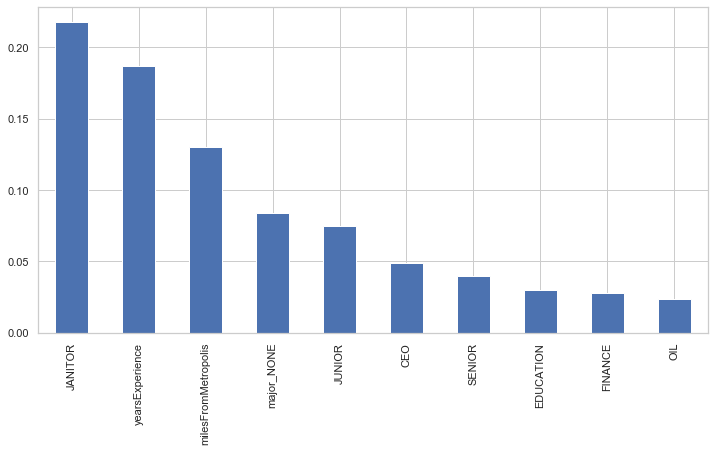

In [35]:
#showing feature importances
importances = pd.Series(model.feature_importances_, index=df.columns)
importances.nlargest(10).plot(kind='bar', figsize=(12,6))
plt.show()

#saving feature importances
np.savetxt('salary_importances.csv', importances, delimiter=',')

## SUMMARY

I have developed a model that is predicting future salaries of job postings based on salaries of current job postings. After performing the exploratory data analysis, I  fitted three models and compared their mean squared errors, basically comparing how well the models performed comparing to the baseline model, and also each other. The model performing the best with the train data was the gradient boosting model. I saved the model, scored the test data with it, and saved the results of the prediction in a csv file. I also included the analysis of feature importances, and saved it in a separate file.